In [ ]:
# ==== CÀI ĐẶT & IMPORT ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Accuracy: 71.88 %


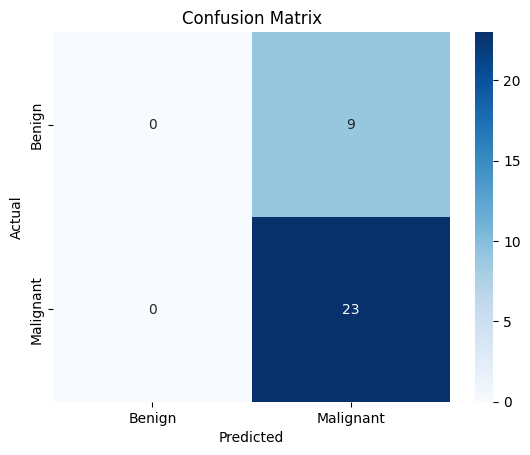

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00         9
   Malignant       0.72      1.00      0.84        23

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32



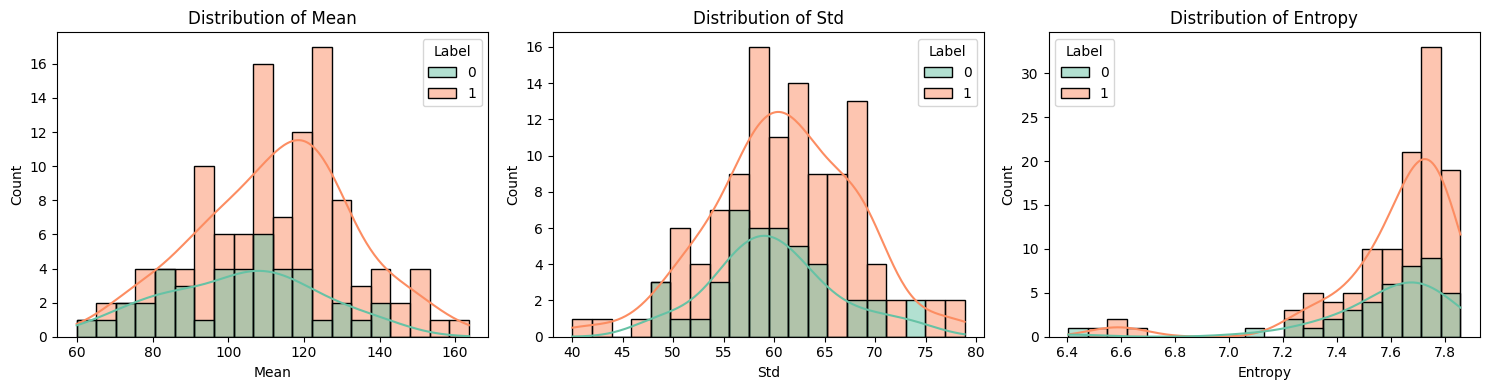


Generating sample images in: synthetic_classified_images/


<ipython-input-8-6465472817a1>:19: RuntimeWarning: overflow encountered in scalar add
  image[i, j] = min(255, image[i, j] + int(50 * (1 - dist/radius)))
<ipython-input-8-6465472817a1>:19: RuntimeWarning: overflow encountered in scalar add
  image[i, j] = min(255, image[i, j] + int(50 * (1 - dist/radius)))
<ipython-input-8-6465472817a1>:19: RuntimeWarning: overflow encountered in scalar add
  image[i, j] = min(255, image[i, j] + int(50 * (1 - dist/radius)))


✓ Images saved successfully.


In [ ]:
# ==== HÀM TẠO ẢNH MÔ PHỎNG ====
def create_synthetic_breast_image(features, label, size=(64, 64)):
    mean_val, std_val, entropy_val = features
    np.random.seed(int(entropy_val * 100) % 1000)
    base_noise = np.random.normal(0, std_val / 100, size)
    x, y = np.meshgrid(np.linspace(0, 1, size[0]), np.linspace(0, 1, size[1]))
    pattern = mean_val / 255 + 0.3 * np.sin(entropy_val * x * np.pi) * np.cos(entropy_val * y * np.pi)
    image = pattern + base_noise
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)

    if label == 1:
        cx, cy = size[0]//2, size[1]//2
        radius = min(size)//6
        for i in range(size[0]):
            for j in range(size[1]):
                dist = np.sqrt((i - cx)**2 + (j - cy)**2)
                if dist < radius:
                    image[i, j] = min(255, image[i, j] + int(50 * (1 - dist/radius)))
    return image

# ==== ĐỌC DỮ LIỆU ====
df = pd.read_csv("/content/chandoananhYKhoa_breastmnist.csv")  # Đảm bảo đã upload file CSV lên Colab

feature_cols = ['Mean', 'Std', 'Entropy']
X = df[feature_cols].values.astype('float32')
y = df['Label'].values.astype('int')

# ==== TIỀN XỬ LÝ ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ==== HUẤN LUYỆN MÔ HÌNH ====
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc * 100, 2), "%")

# ==== MA TRẬN NHẦM LẪN ====
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==== BÁO CÁO PHÂN LOẠI ====
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# ==== VẼ PHÂN BỐ ĐẶC TRƯNG ====
plt.figure(figsize=(15, 4))
for i, feature in enumerate(feature_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feature, hue="Label", bins=20, kde=True, palette='Set2')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# ==== HIỂN THỊ ẢNH MÔ PHỎNG TỪ DỰ ĐOÁN ====
output_dir = "synthetic_classified_images"
os.makedirs(output_dir, exist_ok=True)
label_names = {0: "Benign", 1: "Malignant"}

print(f"\nGenerating sample images in: {output_dir}/")
for i in range(min(20, len(X_test))):
    idx = df.index[i]
    original_features = df.loc[idx, feature_cols].values
    true_label = int(y_test[i])
    pred_label = int(y_pred[i])
    synthetic_image = create_synthetic_breast_image(original_features, true_label)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.imshow(synthetic_image, cmap='gray')
    ax1.axis('off')
    ax1.set_title(f"Sample {i+1}\nTrue: {label_names[true_label]}\nPred: {label_names[pred_label]}")

    text = f"""Features:
Mean: {original_features[0]:.2f}
Std: {original_features[1]:.2f}
Entropy: {original_features[2]:.2f}

True: {label_names[true_label]}
Pred: {label_names[pred_label]}"""
    ax2.text(0.1, 0.5, text, fontsize=10, bbox=dict(facecolor='lightyellow'), verticalalignment='center')
    ax2.axis('off')

    plt.tight_layout()
    filename = f"sample_{i+1:02d}_true{true_label}_pred{pred_label}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.close()

print("✓ Images saved successfully.")
